In [1]:
# download pycocotools
!pip install git+https://github.com/alperiox/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/alperiox/cocoapi.git to /tmp/pip-req-build-zz9cw2nw
  Running command git clone --filter=blob:none --quiet https://github.com/alperiox/cocoapi.git /tmp/pip-req-build-zz9cw2nw
  Resolved https://github.com/alperiox/cocoapi.git to commit 571a98e1ec2f16e8cd526767fd84e2c136309226
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=109339 sha256=839f49bcd60c195f79eef3d583da70b322102db3469142db0da8928ef37f8006
  Stored in directory: /tmp/pip-ephem-wheel-cache-z161p5r8/wheels/8e/fc/f3/24daf824c3929e0eace6e743b70e259b36547b802868a93f5e
Successfully built pycocotools


In [2]:
import matplotlib.pyplot as plt
import yaml
import os

In [3]:
# get the scripts for training and COCO-related utility functions

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-02-05 20:27:46--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py'

     0K ...                                                   100% 42.0M=0s

2024-02-05 20:27:46 (42.0 MB/s) - 'engine.py' saved [4063/4063]

--2024-02-05 20:27:46--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Savin

0

In [4]:
!ls /kaggle/input

medical-image-dataset-brain-tumor-detection


In [5]:
!ls /kaggle/input/medical-image-dataset-brain-tumor-detection/"Brain Tumor Detection"

README.txt  data.yaml  test  train  valid


In [6]:
dataset_path = '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection'

In [7]:
os.listdir(dataset_path)

['README.txt', 'data.yaml', 'valid', 'test', 'train']

In [8]:
os.listdir(os.path.join(dataset_path, "valid", "images"))[:5]

['volume_173_slice_120_jpg.rf.fbc560f7ba3588229d13228d941f4e89.jpg',
 'volume_108_slice_59_jpg.rf.21ec09b0dc858d874774fb41faec4358.jpg',
 'volume_93_slice_87_jpg.rf.4737d38c2669658a07f734517981c307.jpg',
 'volume_53_slice_117_jpg.rf.dd6c265dd0b6b6a1bc8eb9887dc9b350.jpg',
 'volume_124_slice_93_jpg.rf.c6d84ba07222583c4a9295e70805f0dc.jpg']

In [9]:
os.listdir(os.path.join(dataset_path, "valid", "labels"))[:5]

['volume_114_slice_79_jpg.rf.fe0c58a00e797af3cbf938f1002b7e2e.txt',
 'volume_24_slice_39_jpg.rf.fd1811e29c9532d9ddff3887d33205c4.txt',
 'volume_196_slice_74_jpg.rf.8740e0d17ebc28a608a07baff30a2c80.txt',
 'volume_125_slice_74_jpg.rf.8bdbc24905a8e3ea3642bd813cfd8404.txt',
 'volume_24_slice_105_jpg.rf.855aeffc069f255fc910bc246236718c.txt']

In [10]:
with open(os.path.join(dataset_path, 'data.yaml'), "r") as stream:
    data = yaml.safe_load(stream)

data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 3,
 'names': ['label0', 'label1', 'label2'],
 'roboflow': {'workspace': 'yousef-ghanem-jzj4y',
  'project': 'brain-tumor-detection-fpf1f',
  'version': 2,
  'license': 'Public Domain',
  'url': 'https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f/dataset/2'}}

In [11]:
!cat /kaggle/input/medical-image-dataset-brain-tumor-detection/"Brain Tumor Detection"/valid/labels/volume_114_slice_79_jpg.rf.fe0c58a00e797af3cbf938f1002b7e2e.txt

0 0.3057553956834532 0.5265151515151515 0.30935251798561153 0.25
1 0.24820143884892087 0.553030303030303 0.2949640287769784 0.3484848484848485
2 0.3057553956834532 0.5303030303030303 0.35251798561151076 0.2727272727272727

tensor([1, 2], dtype=torch.int32) tensor([[ 79.,  87., 122., 113.],
        [ 98.,  98., 102., 100.]])


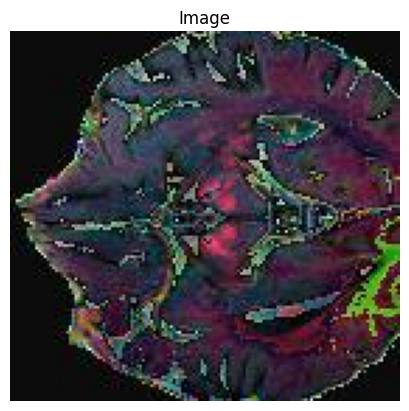

In [12]:
import torch

from torchvision.io import read_image
from torchvision import tv_tensors

from torchvision.utils import draw_bounding_boxes

from torchvision.transforms.v2 import functional as F

from torchvision.ops.boxes import box_area
from torchvision.ops.boxes import box_convert

from glob import glob
from pathlib import Path

from tqdm.auto import tqdm


def plot_tensor(tensor: torch.Tensor, title: str="Image") -> None:
    plt.title(title)
    plt.axis("off")
    plt.imshow(tensor.permute(1,2,0).numpy())
    plt.show()

sample = read_image("/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/images/volume_108_slice_59_jpg.rf.21ec09b0dc858d874774fb41faec4358.jpg")

with open("/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/labels/volume_108_slice_59_jpg.rf.21ec09b0dc858d874774fb41faec4358.txt", "r") as f:
    labels = f.read()

labels = labels.split("\n")
labels = [label.split(" ") for label in labels]
h,w = F.get_size(sample)
label_indices = []
bboxes = []
for label in labels:
    l = int(label[0])
    cx, cy, bw, bh = list(map(float, label[1:]))
    # scale it given the image size
    bbox = [cx*w, cy*h, bw*w, bh*h]
    bbox = torch.Tensor(bbox)
    bbox = box_convert(bbox, in_fmt="cxcywh", out_fmt="xyxy")
    label_indices.append(l)
    bboxes.append(bbox)

labels = torch.tensor(label_indices).to(torch.int)
bboxes = torch.vstack(bboxes).to(torch.float)

print(labels, bboxes)

plot_tensor(sample)

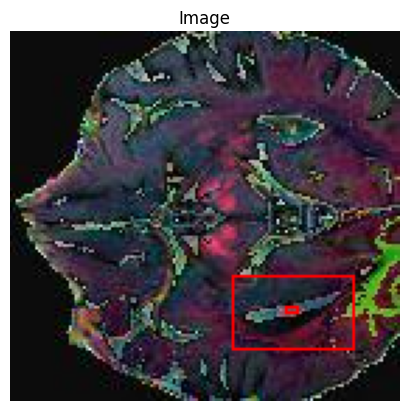

In [13]:
plot_tensor(draw_bounding_boxes(sample, bboxes, colors=[255,255]))

In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        
        self.images = glob(os.path.join(root, "images", "*"))
        # build the label files
        self.labels = []
    
        for image_path in self.images:
            filename_with_ext = image_path.split("/")[-1] # output: {text}.{suffix}
            filename = ".".join(filename_with_ext.split(".")[:-1]) # output: {text}
            label_path = os.path.join(root, "labels", f"{filename}.txt")
            self.labels.append(label_path)
    
        # get the original labels (ensure they're really matching)
        labels = glob(os.path.join(root, "labels", "*.txt"))
        assert sorted(self.labels) == sorted(labels)
    
        # considering that we passed that stage,
        # we should be done with the labels now
        # so we can just process them altogether
        _labels = []
        indices_to_be_removed = []
        bar = tqdm(enumerate(self.labels), desc="Processing labels", total=len(self.labels))
        for idx, label in bar:
            # process the label
            processed_label = self.process_labels_file(label)
            if processed_label[0] == [""]:
                indices_to_be_removed.append(idx)
            else:
                _labels.append(processed_label)
            
            bar.set_description(desc=f"Processing labels, deficit: {len(indices_to_be_removed)}")
        
        self.labels = _labels
        for k, idx in enumerate(indices_to_be_removed, 1):
            del self.images[idx-k]

    def read_file(self, path: Path) -> str:
        with open(path, "r") as f:
            return f.read()
                    
    def process_labels_file(self, path: Path) -> str:
        # read the labels
        labels = self.read_file(path)
        # the file structure as like the following
        # each detection is in new line
        # label x y w h (all coordinates normalized)
        labels = labels.split("\n")
        labels = [label.split(" ") for label in labels]
        bboxes = [label[1:] for label in labels]
        labels = [label[0] for label in labels]
        return labels, bboxes

    def process_labels(self, labels_list: list, bboxes_list: list, h: int, w: int) -> torch.Tensor:
        label_indices = []
        bboxes = []
        for label, bbox in zip(labels_list, bboxes_list):
            l = int(label)
            cx, cy, bw, bh = list(map(float, bbox))
            # scale it given the image size
            bbox = [cx*w, cy*h, bw*w, bh*h]
            bbox = torch.Tensor(bbox)
            bbox = box_convert(bbox, in_fmt="cxcywh", out_fmt="xyxy")
            label_indices.append(l)
            bboxes.append(bbox)
                          
        labels = torch.tensor(label_indices).to(torch.int64)
        bboxes = torch.vstack(bboxes).to(torch.float32)
        
        return labels, bboxes

    def __getitem__(self, idx):
        # get the image and label paths
        image_path = self.images[idx]
        labels, bboxes = self.labels[idx]
        
        image = read_image(image_path)
                      
        h,w = F.get_size(image)
        
        labels, bboxes = self.process_labels(labels, bboxes, h, w)
        
        image = tv_tensors.Image(image)
                      
        iscrowd = torch.zeros((labels.size(0), ), dtype=torch.int64)
        image_id = idx
        area = box_area(bboxes)

        target = {
            "boxes": tv_tensors.BoundingBoxes(bboxes, format="XYXY", canvas_size=[h,w]),
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": image_id
        }

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self) -> int: return len(self.images)

In [15]:
train_dataset = Dataset(os.path.join(dataset_path, "train"))

Processing labels:   0%|          | 0/6930 [00:00<?, ?it/s]

In [16]:
# there isn't any empty entries now.
list(filter(lambda x: "" in x[0], train_dataset.labels))

[]

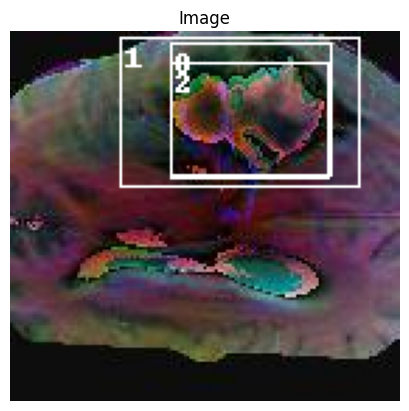

In [17]:
import random

def plot_tensor_with_bbox(sample: tuple, cmap: str=None, colors: int="red", **kwargs) -> None:
    image = sample[0]
    boxes = sample[1]['boxes']
    labels = list(map(str, (sample[1]['labels'].tolist())))
    colors = [colors]*len(labels)
    
    if cmap=="gray": 
        image = F.rgb_to_grayscale_image(image)
    
    image_with_boxes = draw_bounding_boxes(image=image, boxes=boxes, labels=labels, colors=colors,
                                    **kwargs)
    
    plot_tensor(image_with_boxes)

# pick a random index
import random
idx = random.randint(0, len(train_dataset))
random_sample = train_dataset[idx]

# plot the sample
plot_tensor_with_bbox(random_sample, colors="white")

In [18]:
# I can't understand the kind of the tumor in the given images
# as many of the bounding boxes are just inside of each other
# considering that, I'm not sure if a detection model could learn anything
# regarding to classifying the given labels, but at least it might 
# find the bounding boxes.

# start with finetuning a faster rcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

def get_fasterrcnn():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # we need to get the number of input features for the
    # head classifier. 
    # it's place might change from layer (module) to layer (module)
    # depending on the model and the task
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # now we can replace the pre-trained head, we have 3 classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
    
    return model

In [19]:
# define the transformations
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [20]:
# run the model through dataset once
# this is a sanity-check to see if our workflow runs nicely enough.
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
dataset = Dataset(os.path.join(dataset_path, "train"), get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# for training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k,v in t.items()} for t in targets]
output = model(images, targets) # hopefully it'll return losses and detections
print(output)

# and now the inference part
model.eval()
x = [torch.rand(3, 128, 128), torch.rand(3, 200, 300)] # random samples
predictions = model(x)
print(predictions[0])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 170MB/s]


Processing labels:   0%|          | 0/6930 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.2457, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1365, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7502, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.5303, grad_fn=<DivBackward0>)}
{'boxes': tensor([[  0.0000,   0.0000, 128.0000, 128.0000],
        [  1.2805,   0.0000, 127.8269, 128.0000]], grad_fn=<StackBackward0>), 'labels': tensor([72, 82]), 'scores': tensor([0.6037, 0.0801], grad_fn=<IndexBackward0>)}


In [21]:
# since the workflow runs smoothly, we can fine-tune the model completely

from engine import train_one_epoch, evaluate

# find the available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# we have three classes
num_classes = 3
# get the datasets
train_dataset = Dataset(os.path.join(dataset_path, "train"), get_transform(train=True))
valid_dataset = Dataset(os.path.join(dataset_path, "valid"), get_transform(train=False))

# define the dataloaders 
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model
model = get_fasterrcnn()
# move the model to the device
model.to(device)

# now we can define and set up the optimizer,
# we will train the model for a few epochs after that
# since we're finetuning the model, we'll only optimize the
# parameters that we can calculate gradients
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.95,
    weight_decay=0.0005
)

# why not include a learning rate scheduler too?
# StepLR will decay the given learning rate (0.005)
# by the factor of "gamma" every "step_size" steps
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=2,
    gamma=0.1
)

# set up the number of epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    # update the scheduler
    lr_scheduler.step()
    # evaluate on the validation set
    evaluate(model, valid_loader, device=device)

Processing labels:   0%|          | 0/6930 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/1980 [00:00<?, ?it/s]

Epoch: [0]  [  0/857]  eta: 0:50:09  lr: 0.000011  loss: 1.4673 (1.4673)  loss_classifier: 1.2309 (1.2309)  loss_box_reg: 0.1328 (0.1328)  loss_objectness: 0.0895 (0.0895)  loss_rpn_box_reg: 0.0142 (0.0142)  time: 3.5113  data: 0.4230  max mem: 10889
Epoch: [0]  [ 50/857]  eta: 0:16:14  lr: 0.000303  loss: 0.4495 (0.8023)  loss_classifier: 0.1765 (0.5156)  loss_box_reg: 0.1307 (0.1161)  loss_objectness: 0.0873 (0.1494)  loss_rpn_box_reg: 0.0124 (0.0212)  time: 1.1654  data: 0.0179  max mem: 11059
Epoch: [0]  [100/857]  eta: 0:14:58  lr: 0.000594  loss: 0.3885 (0.6340)  loss_classifier: 0.1320 (0.3415)  loss_box_reg: 0.1282 (0.1208)  loss_objectness: 0.0732 (0.1446)  loss_rpn_box_reg: 0.0169 (0.0270)  time: 1.1649  data: 0.0173  max mem: 11059
Epoch: [0]  [150/857]  eta: 0:13:53  lr: 0.000886  loss: 0.3064 (0.5294)  loss_classifier: 0.1115 (0.2653)  loss_box_reg: 0.1146 (0.1190)  loss_objectness: 0.0644 (0.1213)  loss_rpn_box_reg: 0.0108 (0.0238)  time: 1.1646  data: 0.0165  max mem: 11

torch.Size([3, 660, 695]) (660, 695)


/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


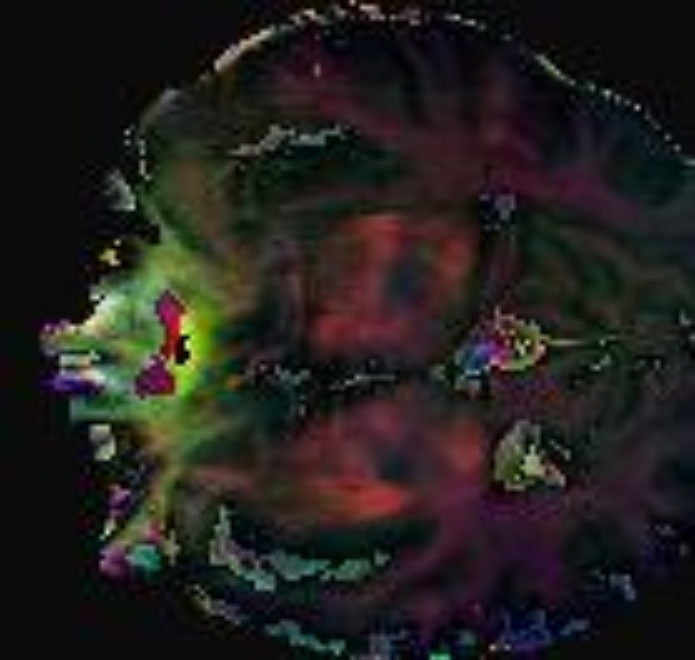

In [22]:
from PIL import Image
from torchvision.ops import nms

# pick a random sample
random_idx = random.randint(0, len(valid_dataset))
sample = valid_dataset[random_idx]

image = sample[0]
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image).to(device)
    predictions = model([x, ])
    pred = predictions[0]
model.train()

# filter the predictions with the threshold of 0.4
pred_mask = (pred['scores'] >= .4).cpu()
# filter more by using non-maximum suppression with .6 as the threshold
nms_idx = nms(pred['boxes'], pred['scores'], .6).cpu()
nms_mask = torch.zeros_like(pred_mask)
nms_mask[nms_idx] = 1

mask = pred_mask * nms_mask # apply "AND" gate by multiplying the two

indices = torch.arange(0, mask.size(0), 1)[mask]

final_preds = {
    "boxes": pred['boxes'][indices, :],
    "labels": pred['labels'][indices],
    "scores": pred['scores'][indices]
}


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_labels = [f"label {label}: {score:.3f}" for label, score in zip(final_preds["labels"], final_preds["scores"])]
pred_boxes = final_preds["boxes"].long()
colors = ["white"]*len(pred_labels)

# resize the image and bounding boxes
pred_boxes = F.resize_bounding_boxes(pred_boxes, canvas_size=F.get_size(image), size=(132*5, 139*5))
image = F.resize(image, (132*5, 139*5), antialias=True)

print(image.shape, pred_boxes[1])

image_with_boxes = draw_bounding_boxes(image=image, boxes=pred_boxes[0], labels=pred_labels, colors=colors)

Image.fromarray(image_with_boxes.permute(1,2,0).numpy())